<a href="https://colab.research.google.com/github/YuanGongND/ast/blob/master/colab/AST_Inference_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [AST: Audio Spectrogram Transformer](https://www.isca-speech.org/archive/interspeech_2021/gong21b_interspeech.html)

This colab script contains the implementation of a minimal demo of pretrained Audio Spectrogram Transformer (AST) inference and attention visualization.

This script is self-contained and can be run in one click, replace the `sample_audio_path` to test your own audio.

Please cite our paper if you find this repository useful.

```
@inproceedings{gong21b_interspeech,
  author={Yuan Gong and Yu-An Chung and James Glass},
  title={{AST: Audio Spectrogram Transformer}},
  year=2021,
  booktitle={Proc. Interspeech 2021},
  pages={571--575},
  doi={10.21437/Interspeech.2021-698}
}
```
For more information, please check https://github.com/YuanGongND/ast

## Step 1. Install and import required packages.

In [29]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/YuanGongND/ast
    sys.path.append('./ast')
%cd ../

! pip install timm==0.4.5
! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = '/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/audioSet-Pretrained/pretrained_models'
# if os.path.exists('/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/audioSet-Pretrained/pretrained_models') == False:
#   os.mkdir('/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/audioSet-Pretrained/pretrained_models')

sys.path.insert(0, "/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/audioSet-Pretrained/src/")

import importlib.util
spec = importlib.util.spec_from_file_location("dataloader", "/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/audioSet-Pretrained/src/dataloader.py")
dataloader = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dataloader)

import torch, torchaudio, timm
import numpy as np
from torch.cuda.amp import autocast
import IPython
# import dataloader
import models
from utilities import *
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/Users/avtar/miniconda3/envs/l3d_2024f_cpu/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/avtar/Library/CloudStorage/OneDrive-Tufts
2005.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2011.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## Step 2. Create AST model and load AudioSet pretrained weights.
The pretrained model achieves 45.93 mAP on the AudioSet evaluation set, which is the best single model in the paper. 

In [30]:
import sys
sys.path.append('../')
from src.models import ASTModel

# Create a new class that inherits the original ASTModel class
# class ASTModelVis(ASTModel):
#     def get_att_map(self, block, x):
#         qkv = block.attn.qkv
#         num_heads = block.attn.num_heads
#         scale = block.attn.scale
#         B, N, C = x.shape
#         qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
#         q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
#         attn = (q @ k.transpose(-2, -1)) * scale
#         attn = attn.softmax(dim=-1)
#         return attn

#     def forward_visualization(self, x):
#         # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
#         x = x.unsqueeze(1)
#         x = x.transpose(2, 3)

#         B = x.shape[0]
#         x = self.v.patch_embed(x)
#         cls_tokens = self.v.cls_token.expand(B, -1, -1)
#         dist_token = self.v.dist_token.expand(B, -1, -1)
#         x = torch.cat((cls_tokens, dist_token, x), dim=1)
#         x = x + self.v.pos_embed
#         x = self.v.pos_drop(x)
#         # save the attention map of each of 12 Transformer layer
#         att_list = []
#         for blk in self.v.blocks:
#             cur_att = self.get_att_map(blk, x)
#             att_list.append(cur_att)
#             x = blk(x)
#         return att_list

def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    # assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    # print(f'[*INFO] {wav_name} has {n_frames} frames')
    # print(f'[*INFO] {wav_name} has dimensions {fbank.shape} and type {fbank.dtype}')
    
    # import matplotlib.pyplot as plt

    # plt.imshow(fbank.T, aspect='auto', origin='lower')
    # plt.title('Mel Spectrogram')
    # plt.xlabel('Time')
    # plt.ylabel('Mel Frequency')
    # plt.colorbar(format='%+2.0f dB')
    # plt.show()
    
    # print(f'fbank min: {fbank.min()}, fbank max: {fbank.max()}')
    
    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank


def load_label(label_csv):
    with open(label_csv, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        lines = list(reader)
    labels = []
    ids = []  # Each label has a unique id such as "/m/068hy"
    for i1 in range(1, len(lines)):
        id = lines[i1][1]
        label = lines[i1][2]
        ids.append(id)
        labels.append(label)
    return labels

# Create an AST model and download the AudioSet pretrained weights
# audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
# if os.path.exists('../pretrained_models/audio_mdl.pth') == False:
#   wget.download(audioset_mdl_url, out='../pretrained_models/audio_mdl.pth')



In [31]:
audio_model = models.ASTModel(label_dim=12, fstride=10, tstride=10, input_fdim=128,
input_tdim=1024, imagenet_pretrain=True,
audioset_pretrain=False, model_size='base384')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = '/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/exp/birdclef_audio1/models/best_audio_model.pth'
# # now load the visualization model
# ast_mdl = ASTModelVis(label_dim=12, input_tdim=input_tdim, imagenet_pretrain=True, audioset_pretrain=False)
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location=device)

# Remove 'module.' prefix from keys
state_dict = checkpoint
new_state_dict = {}
for k, v in state_dict.items():
    name = k[7:] if k.startswith('module.') else k  # remove 'module.' prefix
    new_state_dict[name] = v

audio_model.load_state_dict(new_state_dict)
audio_model = audio_model.to(device)
audio_model.eval()          

# Load the AudioSet label set
label_csv = '/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/audioSet-Pretrained/egs/audioset/data/bird_class_labels_indices.csv'       # label and indices for audioset data
labels = load_label(label_csv)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: /Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/exp/birdclef_audio1/models/best_audio_model.pth


/var/folders/md/s3kx95_13hb51505hrc358j00000gn/T/ipykernel_63313/3416961813.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map

In [32]:
def validate(audio_model, val_loader, args, epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_time = AverageMeter()
    if not isinstance(audio_model, nn.DataParallel):
        audio_model = nn.DataParallel(audio_model)
    audio_model = audio_model.to(device)
    # switch to evaluate mode
    audio_model.eval()

    end = time.time()
    A_predictions = []
    A_targets = []
    A_loss = []
    with torch.no_grad():
        for i, (audio_input, labels) in enumerate(val_loader):

            print(audio_input.shape)
            print(labels.shape)

            print(type(audio_input))
            print(type(labels))
            
            audio_input = audio_input.to(device)

            # compute output
            audio_output = audio_model(audio_input)
            audio_output = torch.sigmoid(audio_output)
            predictions = audio_output.to('cpu').detach()

            A_predictions.append(predictions)
            A_targets.append(labels)

            # compute the loss
            labels = labels.to(device)
            if isinstance(args.loss_fn, torch.nn.CrossEntropyLoss):
                loss = args.loss_fn(audio_output, torch.argmax(labels.long(), axis=1))
            else:
                loss = args.loss_fn(audio_output, labels)
            A_loss.append(loss.to('cpu').detach())

            batch_time.update(time.time() - end)
            end = time.time()

        audio_output = torch.cat(A_predictions)
        target = torch.cat(A_targets)
        loss = np.mean(A_loss)
        stats = calculate_stats(audio_output, target)

        # save the prediction here
        exp_dir = args.exp_dir
        if os.path.exists(exp_dir+'/predictions') == False:
            os.mkdir(exp_dir+'/predictions')
            np.savetxt(exp_dir+'/predictions/target.csv', target, delimiter=',')
        np.savetxt(exp_dir+'/predictions/predictions_' + str(epoch) + '.csv', audio_output, delimiter=',')

    return stats, loss

## Step 3. Load an audio and predict the sound class.
By default we test one sample from another dataset (VGGSound) that has not been seen during the model training.

For this very specific sample, it is a parrot mimicing human speech and there's a bird chirp in the middle, that's why the model predicts it is a mixture of speech and bird sound. This audio is extracted from a Youtube video, and the video looks like this (note: only audio is used for prediction): 

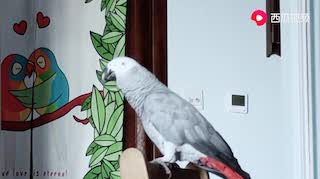

Replace the `sample_audio_path` to test your own audio.

In [33]:
import os
import wget
import torch
import numpy as np
from torch.cuda.amp import autocast
# from dataloader import AudiosetDataset
import IPython.display
print("dataloader.py file: " + dataloader.__file__);

# Get a sample audio and make feature for predict
# change url to play with the script
#sample_audio_path = 'https://www.dropbox.com/s/kx8s8irzwj6nbeq/glLQrEijrKg_000300.flac?dl=1'

# # some other samples
sample_audio_path = 'https://www.dropbox.com/s/vddohcnb9ane9ag/LDoXsip0BEQ_000177.flac?dl=1'
#sample_audio_path = 'https://www.dropbox.com/s/omned2muw8cyunf/6jiO0tPLK7U_000090.flac?dl=1'

pathToCode = "/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/"
te_data = f"{pathToCode}Data/test_audio.json"

class Args:
    pass

args = Args()
args.alen = 5
args.audio_length = 1024
args.audioset_pretrain = False
args.bal ='bal'
args.batch_size =12
args.data_eval ='/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/Data/test_audio.json'
args.data_train ='/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/Data/train_audio.json'
args.data_val ='/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/Data/val_audio.json'
args.dataset ='audioset'
args.dataset_mean =-4.2677393
args.dataset_std =4.5689974
args.exp_dir ='./exp/birdclef_audio1x'
args.freqm =48
args.fstride =10
args.imagenet_pretrain =True
args.label_csv ='/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/audioSet-Pretrained/egs/audioset/data/bird_class_labels_indices.csv'
args.loss ='BCE'
args.lr =1e-05
args.lrscheduler_decay =0.5
args.lrscheduler_start =2
args.lrscheduler_step =1
args.metrics ='mAP'
args.mixup =0.5
args.model ='ast'
args.n_class =12
args.n_epochs =5
args.n_print_steps =100
args.noise =False
args.num_workers =0
args.optim ='adam'
args.save_model =True
args.timem =192
args.tstride =10
args.wa =True
args.wa_end =5
args.wa_start =1
args.warmup =True

te_audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0, 'dataset': 'imageNet', 'mode':'evaluation', 'mean':-4.2677393, 'std':4.5689974, 'noise':False}

class_indices = f"{pathToCode}audioSet-Pretrained/egs/audioset/data/bird_class_labels_indices.csv"
print("class_indices: " + class_indices)

input_tdim = 1024  # Define input_tdim

te_loader = torch.utils.data.DataLoader(
    dataloader.AudiosetDataset(te_data, label_csv=class_indices, audio_conf=te_audio_conf),
    batch_size=12*2, shuffle=False, num_workers=0, pin_memory=True)

# for i, (audio_input, labels) in enumerate(te_loader):
#     B = audio_input.size(0)
#     audio_input = audio_input.to(device, non_blocking=True)
#     labels = labels.to(device, non_blocking=True)

#     feats = make_features('/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/audioSet-Pretrained/sample_audios/XC37740.ogg', mel_bins=128) 

#     feats_data = feats.expand(1, input_tdim, 128)  # reshape the feature
#     feats_data = feats_data.to(device)

#     # Make the prediction
#     with torch.no_grad():
#         with autocast():
#             output = audio_model.forward(feats_data)
#             output = torch.sigmoid(output)
#     result_output = output.data.cpu().numpy()[0]
#     sorted_indexes = np.argsort(result_output)[::-1]

#     # Print audio tagging top probabilities
#     print('Predice results:')
#     for k in range(10):
#         print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))

stats, _ = validate(audio_model, te_loader, args, 1)
print('Listen to this sample: ')

# # IPython.display.Audio('../sample_audios/sample_audio.flac')
# import torch
# import numpy as np
# from torch.cuda.amp import autocast
# from dataloader import AudiosetDataset
# from utils import make_features
# import IPython.display

# # Get a sample audio and make feature for predict
# # change url to play with the script
# #sample_audio_path = 'https://www.dropbox.com/s/kx8s8irzwj6nbeq/glLQrEijrKg_000300.flac?dl=1'

# # # some other samples
# sample_audio_path = 'https://www.dropbox.com/s/vddohcnb9ane9ag/LDoXsip0BEQ_000177.flac?dl=1'
# #sample_audio_path = 'https://www.dropbox.com/s/omned2muw8cyunf/6jiO0tPLK7U_000090.flac?dl=1'

# pathToCode = "/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/"
# te_data = f"{pathToCode}Data/test_audio.json"

# te_audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0, 'dataset': 'imageNet', 'mode':'evaluation', 'mean':-4.2677393, 'std':4.5689974, 'noise':False}

# class_indices = f"{pathToCode}audioSet-Pretrained/egs/audioset/data/bird_class_labels_indices.csv"

# device = torch.device("cuda" if torch.cuda.is_available() else "mps")

# input_tdim = 1024  # Define input_tdim

# te_loader = torch.utils.data.DataLoader(
#     AudiosetDataset(te_data, label_csv=class_indices, audio_conf=te_audio_conf),
#     batch_size=12*2, shuffle=False, num_workers=4, pin_memory=True)

# for i, (audio_input, labels) in enumerate(te_loader):
#     B = audio_input.size(0)
#     audio_input = audio_input.to(device, non_blocking=True)
#     labels = labels.to(device, non_blocking=True)

#     feats = make_features('/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/audioSet-Pretrained/sample_audios/XC37740.ogg', mel_bins=128) 

#     feats_data = feats.expand(1, input_tdim, 128)  # reshape the feature
#     feats_data = feats_data.to(device)

#     # Make the prediction
#     with torch.no_grad():
#         with autocast():
#             output = audio_model.forward(feats_data)
#             output = torch.sigmoid(output)
#     result_output = output.data.cpu().numpy()[0]
#     sorted_indexes = np.argsort(result_output)[::-1]

#     # Print audio tagging top probabilities
#     print('Predice results:')
#     for k in range(10):
#         print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))

# print('Listen to this sample: ')
# IPython.display.Audio('../sample_audios/sample_audio.flac')

dataloader.py file: /Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/audioSet-Pretrained/src/dataloader.py
class_indices: /Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/audioSet-Pretrained/egs/audioset/data/bird_class_labels_indices.csv
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process imageNet
use dataset mean -4.268 and std 4.569 to normalize the input.
number of classes is 12


LibsndfileError: Error opening 'Data/Audio/grewar3/XC189949.ogg': System error.

## Step 4.a. Visualize the mean attention map of all attention heads for each layer
Note the model focuses on the middle high frequency bird chirp as well as the low frequency speech.

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)
for i in range(len(att_list)):
  att_list[i] = att_list[i].data.cpu().numpy()
  att_list[i] = np.mean(att_list[i][0], axis=0)
  att_list[i] = np.mean(att_list[i][0:2], axis=0)
  att_list[i] = att_list[i][2:].reshape(12, 101)
  plt.imshow(att_list[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()

## Step 4.b. Visualize the attention map of each attention head of a specific layer
Note the attention map of heads are quite diverse.

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)

# the layer of interest
i = 11

att_map = att_list[i].data.cpu().numpy()
att_map = att_map[0]
att_map = np.mean(att_map[:, 0:2, :], axis=1)
att_map = att_map[:, 2:].reshape(12, 12, 101)
for j in range(12):
  plt.imshow(att_map[j], origin='lower')
  plt.title('Mean Attention Map of Head #{:d} Layer #{:d}'.format(j, i))
  plt.show()
  plt.close()